# Hyperparameter Tuning for Deep Neural Network Classifier
**Prepared by:** Yongli Chen and Adisorn Promkaewngarm

# Import Library

In [1]:
!pip -q install mplfinance

In [2]:
!pip -q install tensorflow

In [3]:
!pip install keras_tuner

In [4]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

#from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt


import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import class_weight
import seaborn as sns
import matplotlib.pyplot as plt
import mplfinance as mpf


import os, random #, multiprocessing, psutil
from google.colab import output

In [5]:
# Setting for Reproducibility
# 1. Set the Seed for Python's built-in random
os.environ['PYTHONHASHSEED'] = '0'
random.seed(42)

# 2. Set the Seed for NumPy (Data shuffling/splitting)
np.random.seed(42)

# 3. Set the Seed for TensorFlow (Weight initialization)
tf.random.set_seed(42)

# 4. Force TensorFlow to use deterministic operations (New in TF 2.9+)
# Note: This might make training slightly slower, but guarantees exact results.
os.environ['TF_DETERMINISTIC_OPS'] = '1'
try:
    tf.config.experimental.enable_op_determinism()
except AttributeError:
    print("Warning: enable_op_determinism not found (Update TensorFlow if needed)")

print("Global Seeds Set: Reproducibility Mode ON")

Global Seeds Set: Reproducibility Mode ON


# Import Data

In [6]:
# GitHub Raw Data Paths
path_feature = 'https://raw.githubusercontent.com/adisorn242/2026_WQU_CapstoneProject/main/df_SET_features_weekly.csv'
path_label_train = 'https://raw.githubusercontent.com/adisorn242/2026_WQU_CapstoneProject/main/df_regime_labeling_traindata_weekly.csv'
path_set_data = 'https://raw.githubusercontent.com/adisorn242/2026_WQU_CapstoneProject/main/SET_Index_Weekly_2010_2025.csv'

# 1. Load the feature set
df_features = pd.read_csv(path_feature, index_col=0, parse_dates=True)

  # Train-Test split by period
df_features_train = df_features.loc[df_features.index.year < 2023].copy()
df_features_train = df_features_train.iloc[:, 1:] # Remove currnet return
df_features_train = df_features_train[[
    col for col in df_features_train.columns
    if 'lag' not in col or int(col.split('lag')[-1].replace('_', '')) <= 12
]]   # Filter to get only lag1 to lag12

  # Train-Test split by period
df_features_test = df_features.loc[df_features.index.year >= 2023,].copy()
df_features_test = df_features_test.iloc[:, 1:] # Remove currnet return
df_features_test = df_features_test[[
    col for col in df_features_test.columns
    if 'lag' not in col or int(col.split('lag')[-1].replace('_', '')) <= 12
]] # Filter to get only lag1 to lag12

# 2. Load the training labels
df_labels = pd.read_csv(path_label_train, index_col=0, parse_dates=True)
df_labels_train = df_labels['Regime_ID'].copy()

# 3. Load the raw SET Index OHLC data
df_set_index = pd.read_csv(path_set_data, index_col=0, parse_dates=True)

In [7]:
# 1. Check Training Set Alignment (Features vs. GM-HMM Labels)
train_indices_match = df_features_train.index.equals(df_labels_train.index)

# Define df_set_index_test here to resolve NameError
df_set_index_test = df_set_index.loc[df_set_index.index.year >= 2023].copy()

# 2. Check Testing Set Alignment (Features vs. Raw SET Index)
test_indices_match = df_features_test.index.equals(df_set_index_test.index)

# 3. Print Results
print("="*50)
print("INDEX CONSISTENCY VERIFICATION")
print("="*50)
print(f"Training Set Indices Match: {train_indices_match}")
print(f"Testing Set Indices Match:  {test_indices_match}")
print("-" * 50)

# If they don't match, let's see where the discrepancy is
if not train_indices_match:
    print(f"Training Features: {len(df_features_train)} rows")
    print(f"Training Labels:   {len(df_labels_train)} rows")
    # Finding the difference
    diff = df_features_train.index.difference(df_labels_train.index)
    print(f"Missing dates in labels: {len(diff)}")

if not test_indices_match:
    print(f"Testing Features:  {len(df_features_test)} rows")
    print(f"Testing SET Data:  {len(df_set_index_test)} rows")
print("="*50)

INDEX CONSISTENCY VERIFICATION
Training Set Indices Match: True
Testing Set Indices Match:  True
--------------------------------------------------


# Data Normalization

In [8]:
# 1. Initialize the Scaler
scaler = StandardScaler()

# 2. Fit and Transform the Training Data
X_train_scaled = scaler.fit_transform(df_features_train)

# 3. Transform the Testing Data (using the training parameters)
X_test_scaled = scaler.transform(df_features_test)

# Convert back to DataFrame to maintain column names for XGBoost
X_train_final = pd.DataFrame(X_train_scaled, index=df_features_train.index, columns=df_features_train.columns)
X_test_final = pd.DataFrame(X_test_scaled, index=df_features_test.index, columns=df_features_test.columns)

In [9]:
# GPU CONFIGURATION
print(f"TensorFlow version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"GPUs Available: {len(gpus)}")
else:
    print("No GPU available, using CPU")

TensorFlow version: 2.19.0
GPUs Available: 1


# Hyperparameter Tuning

In [10]:
# Ensure labels are correct format for Keras
y_train_indices = df_labels_train.values.astype(int)

In [11]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.Input(shape=(X_train_final.shape[1],)))

    # --- Hidden Layer 1 ---
    hp_units_1 = hp.Choice('units_1', values=[32, 64, 128, 256])
    hp_act_1 = hp.Choice('activation_1', values=['relu', 'sigmoid', 'leaky_relu', 'tanh'])

    if hp_act_1 == 'leaky_relu':
        model.add(layers.Dense(units=hp_units_1))
        model.add(layers.LeakyReLU(alpha=0.1))
    else:
        model.add(layers.Dense(units=hp_units_1, activation=hp_act_1))

    # Batch Norm and Dropout for Layer 1
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))

    # --- Hidden Layer 2 ---
    hp_units_2 = hp.Choice('units_2', values=[8, 16, 32, 64])
    hp_act_2 = hp.Choice('activation_2', values=['relu', 'sigmoid', 'leaky_relu', 'tanh'])

    if hp_act_2 == 'leaky_relu':
        model.add(layers.Dense(units=hp_units_2))
        model.add(layers.LeakyReLU(alpha=0.1))
    else:
        model.add(layers.Dense(units=hp_units_2, activation=hp_act_2))

    # Batch Norm and Dropout for Layer 2
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))

    # --- Output Layer ---
    model.add(layers.Dense(3, activation='softmax'))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [12]:
import time
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# 1. Define the Custom Tuner for Time Series Cross-Validation
class TimeSeriesCVTuner(kt.RandomSearch):
    def run_trial(self, trial, x, y, **kwargs):
        # Setup 5-Fold Time Series Split
        tscv = TimeSeriesSplit(n_splits=5)
        val_accuracy_scores = []

        for fold, (train_indices, val_indices) in enumerate(tscv.split(x)):
            x_train, x_val = x[train_indices], x[val_indices]
            y_train, y_val = y[train_indices], y[val_indices]

            # Build the model based on current trial hyperparameters
            model = self.hypermodel.build(trial.hyperparameters)

            # Fit the model for this specific fold
            model.fit(
                x_train, y_train,
                validation_data=(x_val, y_val),
                epochs=kwargs.get('epochs', 50),
                batch_size=kwargs.get('batch_size', 32),
                callbacks=kwargs.get('callbacks', []),
                verbose=0 # Keep it quiet during folds
            )

            # Evaluate Accuracy on validation fold
            y_pred_probs = model.predict(x_val, verbose=0)
            y_pred = np.argmax(y_pred_probs, axis=1)
            score = accuracy_score(y_val, y_pred)
            val_accuracy_scores.append(score)

            print(f"  > Trial {trial.trial_id} - Fold {fold+1} Accuracy: {score:.4f}")

        # Calculate the Average Accuracy across all 5 folds
        avg_acc = np.mean(val_accuracy_scores)

        # Update the oracle with the mean accuracy score
        self.oracle.update_trial(trial.trial_id, {'val_accuracy': avg_acc})

In [13]:
# 2. Hyperparameter Tuning Switch
run_tuning = False

if run_tuning:
    # Initialize the custom TimeSeriesCVTuner
    tuner = TimeSeriesCVTuner(
        build_model,
        objective=kt.Objective("val_accuracy", direction="max"),
        max_trials=30,
        directory='keras_tuning_dir',
        project_name='market_regime_dnn_tscv',
        overwrite=True,
        seed=42
    )

    print("Starting Keras Tuner with 5-Fold Time-Series CV (Accuracy)...")
    start_time = time.time()

    # Run Search
    # Note: We pass the full training set; the tuner handles the splitting
    tuner.search(
        X_train_final.values,
        y_train_indices,
        epochs=50,
        batch_size=64,
        callbacks=[stop_early],
        verbose=1
    )

    duration = time.time() - start_time

    # Audio notification
    try:
        from google.colab import output
        output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')
    except: pass

    # Results
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_score = tuner.oracle.get_best_trials(1)[0].score

    print("\n" + "="*50)
    print(f"TUNING COMPLETED")
    print(f"Total Time Spent:  {duration:.2f} seconds ({duration/60:.2f} minutes)")
    print(f"Best Avg Accuracy: {best_score:.4f}")
    print("-" * 50)
    print(f"Best L1 Units:      {best_hps.get('units_1')}")
    print(f"Best L1 Activation: {best_hps.get('activation_1')}")
    print(f"Best L2 Units:      {best_hps.get('units_2')}")
    print(f"Best L2 Activation: {best_hps.get('activation_2')}")
    print(f"Best Dropout 1:     {best_hps.get('dropout_1'):.2f}")
    print(f"Best Dropout 2:     {best_hps.get('dropout_2'):.2f}")
    print("="*50)
else:
    print("Skipping tuning.")

Skipping tuning.


unit 1: 64 activation: leaky_relu, dropout_1 = 0.3

unit 2: 16, activation: relu, drouout_2 = 0.2

# Fitting Model

In [14]:
if run_tuning:
  # 1. Build and Train Final Model
  final_dnn_model = tuner.hypermodel.build(best_hps)

  # Print The Summary Table
  print("Model Architecture:")
  final_dnn_model.summary()

In [15]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# --- 1. APPLY REPRODUCIBILITY SEEDS ---
os.environ['PYTHONHASHSEED'] = '0'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Force deterministic operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'
try:
    tf.config.experimental.enable_op_determinism()
except AttributeError:
    print("Warning: enable_op_determinism not found.")

# --- 2. BUILD THE CHAMPION MODEL ---
if not run_tuning:
    print("Building the 'Champion' Model using best hyperparameters...")

    final_dnn_model = keras.Sequential()
    final_dnn_model.add(keras.Input(shape=(X_train_final.shape[1],)))

    # Layer 1:
    final_dnn_model.add(layers.Dense(64, activation='leaky_relu'))
    final_dnn_model.add(layers.BatchNormalization())
    final_dnn_model.add(layers.Dropout(0.3))

    # Layer 2:
    final_dnn_model.add(layers.Dense(16, activation='relu'))
    final_dnn_model.add(layers.BatchNormalization())
    final_dnn_model.add(layers.Dropout(0.))

    # Output: 3 Classes (Softmax for Regime Detection)
    final_dnn_model.add(layers.Dense(3, activation='softmax'))

    # Compile with the same settings used during tuning
    final_dnn_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    print("\nChampion Model Architecture:")
    final_dnn_model.summary()

Building the 'Champion' Model using best hyperparameters...

Champion Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,755 (10.76 KB)

 Trainable params: 2,595 (10.14 KB)

 Non-trainable params: 160 (640.00 B)

In [16]:
history = final_dnn_model.fit(
    X_train_final.values,
    y_train_indices,
    epochs=50,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)],
    verbose=1
)
print("Final Model Training Complete.")

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.3679 - loss: 1.5689 - val_accuracy: 0.4206 - val_loss: 1.0716
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4203 - loss: 1.3592 - val_accuracy: 0.3968 - val_loss: 1.0654
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4354 - loss: 1.2177 - val_accuracy: 0.4365 - val_loss: 1.0664
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4871 - loss: 1.1409 - val_accuracy: 0.4286 - val_loss: 1.0682
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4897 - loss: 1.0772 - val_accuracy: 0.4365 - val_loss: 1.0701
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4803 - loss: 1.0647 - val_accuracy: 0.4286 - val_loss: 1.0687
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4727 - loss: 1.0342 - val_accuracy: 0.3889 - val_loss: 1.0759
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5134 - loss: 0.9997 - val_accuracy: 0.3968 - v

In [17]:
# 2. Predictions
# Predict probabilities
y_train_prob = final_dnn_model.predict(X_train_final.values)
y_test_prob = final_dnn_model.predict(X_test_final.values)

# Convert to class (0, 1, 2)
y_train_pred = np.argmax(y_train_prob, axis=1)
y_test_pred = np.argmax(y_test_prob, axis=1)

print("Regime Distribution in Test Set Predictions:")
print(pd.Series(y_test_pred).value_counts().sort_index())

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Regime Distribution in Test Set Predictions:
0    126
1     12
2     19
Name: count, dtype: int64


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
TRAINING SET PERFORMANCE (IN-SAMPLE: 2011-2022)
              precision    recall  f1-score   support

    Sideways       0.53      0.88      0.66       249
        Bull       0.47      0.19      0.27       201
        Bear       0.63      0.47      0.54       176

    accuracy                           0.54       626
   macro avg       0.54      0.51      0.49       626
weighted avg       0.54      0.54      0.50       626



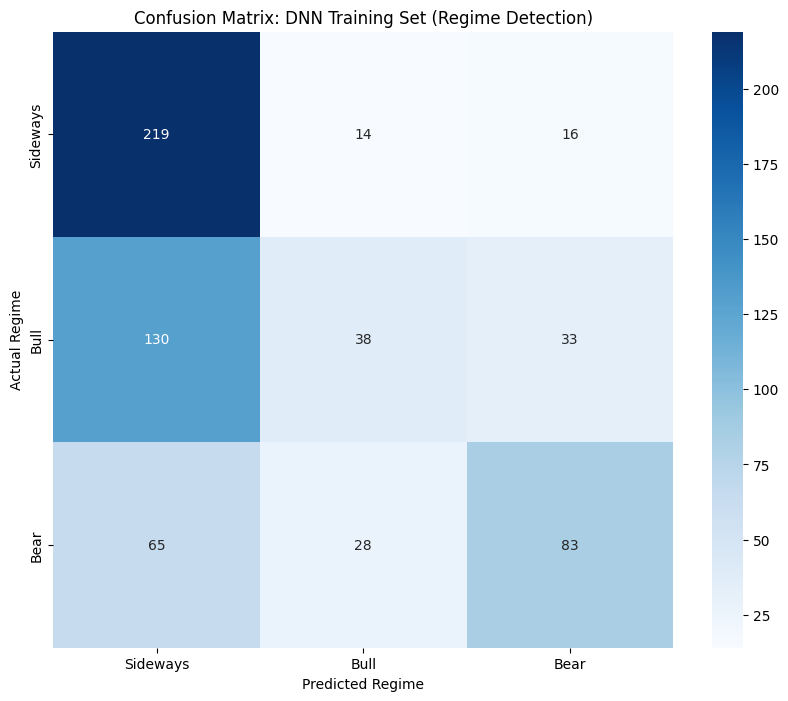

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Generate Predictions
# Use predict and argmax to get the class indices (0, 1, 2)
y_train_probs = final_dnn_model.predict(X_train_final.values)
y_train_pred = np.argmax(y_train_probs, axis=1)

# 2. Performance Metrics
print("="*60)
print("TRAINING SET PERFORMANCE (IN-SAMPLE: 2011-2022)")
print("="*60)

# Added target_names to match your 0, 1, 2 mapping
target_names = ['Sideways', 'Bull', 'Bear']
print(classification_report(y_train_indices, y_train_pred, target_names=target_names))

# 3. Confusion Matrix Visualization
cm_train = confusion_matrix(y_train_indices, y_train_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_train,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=target_names, # [Sideways, Bull, Bear]
    yticklabels=target_names  # [Sideways, Bull, Bear]
)

plt.title('Confusion Matrix: DNN Training Set (Regime Detection)')
plt.xlabel('Predicted Regime')
plt.ylabel('Actual Regime')
plt.show()

# Save Model

In [19]:
if False: # Set true to export model
  model_filename = 'model_DNN_regime_prediction.json'
  best_dnn_model.save_model(model_filename)